## VCB

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Nadam

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../../Dataset/VCB.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (70/30)
train_size = int(len(y_norm) * 0.7)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) 
model.add(Dense(50, activation='relu'))                            
model.add(Dense(n_forecast))                                       

optimizer = Nadam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=32, verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/200


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4337e-04 - val_loss: 0.0011
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6683e-04 - val_loss: 7.5856e-04
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4293e-04 - val_loss: 7.2668e-04
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0773e-04 - val_loss: 5.5954e-04
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1219e-04 - val_loss: 5.4122e-04
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7784e-04 - val_loss: 5.2840e-04
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0059e-04 - val_loss: 5.1467e-04
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6723e-04 - val_loss: 4.9979e-04
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6044e-04 - val_loss: 4.8384e-04
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3391e-04 - val_loss: 4.7120e-04

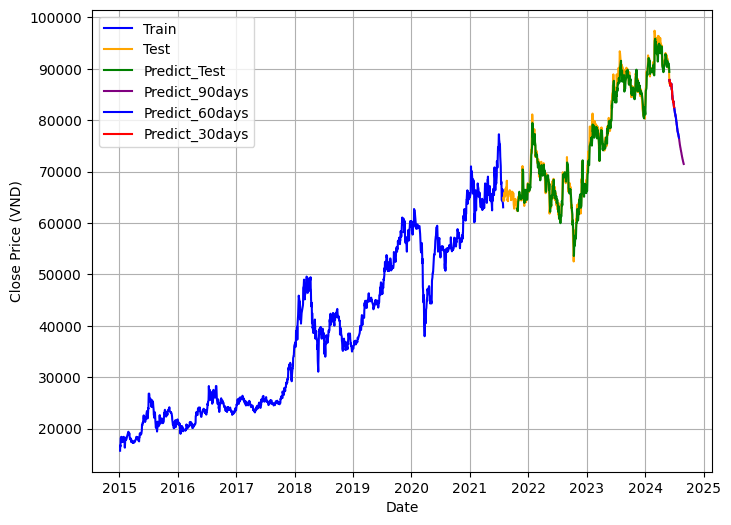

In [3]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('VCB Stock Price Forecast using LSTM 7:3')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [4]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast VCB stock prices for the next 90 days:")
print(future_df)


Forecast VCB stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  87808.992188
2024-06-02  87583.835938
2024-06-03  87658.562500
2024-06-04  87273.468750
2024-06-05  87119.804688
...                  ...
2024-08-25  71978.765625
2024-08-26  71825.765625
2024-08-27  71722.562500
2024-08-28  71575.789062
2024-08-29  71476.218750

[90 rows x 1 columns]


In [5]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 1419.8478676460418
MAPE: 1.4342744819680453 %
MAE: 1081.1514432437693


## CTG

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../../Dataset/CTG.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (70/30)
train_size = int(len(y_norm) * 0.7)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,)))
model.add(Dense(50, activation='relu'))                            
model.add(Dense(n_forecast))         
                              
optimizer = Nadam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=32, verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/200


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0157 - val_loss: 0.0024
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7844e-04 - val_loss: 0.0031
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2076e-04 - val_loss: 0.0022
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2136e-04 - val_loss: 0.0016
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5867e-04 - val_loss: 0.0018
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2800e-04 - val_loss: 0.0014
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1075e-04 - val_loss: 0.0013
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7149e-04 - val_loss: 0.0011
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5631e-04 - val_loss: 0.0012
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3423e-04 - val_loss: 0.0012
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0842e-04 - val_loss: 8.8815e-04
Epoch 12/200
50/50 ━━━━━━━━━━━━

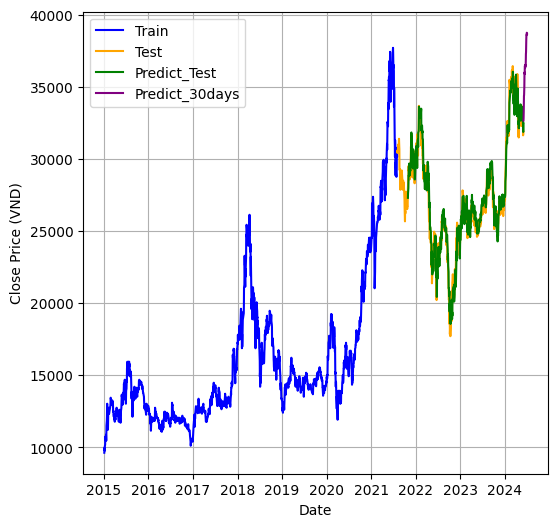

In [7]:
# Visualization
plt.figure(figsize=(6, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='purple')
# plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='red')
# plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')

# plt.title('CTG Stock Price Forecast using MLP 7:3')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [8]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast CTG stock prices for the next 90 days:")
print(future_df)


Forecast CTG stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  32672.486328
2024-06-02  32843.101562
2024-06-03  33253.433594
2024-06-04  33794.718750
2024-06-05  34396.023438
...                  ...
2024-08-25  44244.085938
2024-08-26  44399.578125
2024-08-27  44664.578125
2024-08-28  44937.843750
2024-08-29  45163.148438

[90 rows x 1 columns]


In [9]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 740.3885722992696
MAPE: 2.197009076918472 %
MAE: 582.5640073029891


## BID

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Tải dữ liệu (Không có thay đổi)
data = pd.read_csv('../../Dataset/BID.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu 
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Chia dữ liệu thành train và test (70/30) 
train_size = int(len(y_norm) * 0.7)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Tạo các chuỗi đầu vào và đầu ra 
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Dự đoán từng bước thời gian
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng và huấn luyện mô hình MLP
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,)))
model.add(Dense(50, activation='relu'))                          
model.add(Dense(n_forecast))                                       

optimizer = Nadam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=32, verbose=1)

# Đánh giá trên tập kiểm tra 
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Dự đoán tương lai 
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/200


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0099 - val_loss: 0.0015
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5291e-04 - val_loss: 0.0012
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4873e-04 - val_loss: 0.0014
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8712e-04 - val_loss: 0.0015
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6211e-04 - val_loss: 0.0015
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3660e-04 - val_loss: 0.0014
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1514e-04 - val_loss: 0.0013
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9790e-04 - val_loss: 0.0013
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8344e-04 - val_loss: 0.0012
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6835e-04 - val_loss: 0.0011
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5265e-04 - val_loss: 9.9039e-04
Epoch 12/200
50/50 ━━━━━━━━━━━━

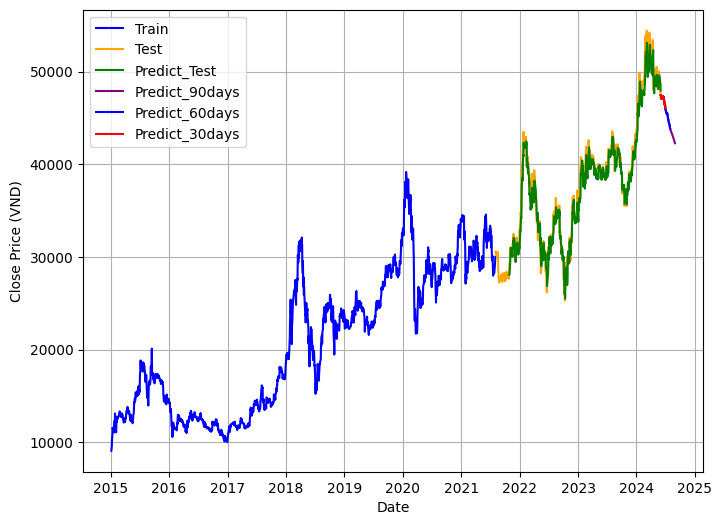

In [11]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('CTG Stock Price Forecast using MLP 7:3')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [12]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast BID stock prices for the next 90 days:")
print(future_df)


Forecast BID stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  47430.144531
2024-06-02  47389.953125
2024-06-03  47419.214844
2024-06-04  47155.421875
2024-06-05  47266.578125
...                  ...
2024-08-25  42490.179688
2024-08-26  42440.644531
2024-08-27  42377.257812
2024-08-28  42329.242188
2024-08-29  42269.062500

[90 rows x 1 columns]


In [13]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 1018.7372832518523
MAPE: 1.962592677117319 %
MAE: 752.0291907269021
